# Using Bayesian inference to rank American football field kickers

Data come from [this paper](http://www.sloansportsconference.com/wp-content/uploads/2013/Going%20for%20Three%20Predicting%20the%20Likelihood%20of%20Field%20Goal%20Success%20with%20Logistic%20Regression.pdf) where players are ranked by their 'career make %'

One of the problems with this type of ranking/sorting is that it ignores the uncertainty of this point estimate ('career make %'). Intuitively we know that having more samples (number of kicks) will give us less uncertainty. For example, a player who scored 98 out of 100 kicks is _more likely_ to be better than a player who scored 1 out of 1 kicks. However calculating the percentages will give you the opposite.

This happens because using an average to estimate the expected number only works if the number of samples is large (ideally infinite).

In this notebook, I am going to tackle this problem by ranking the players using the **95% least plausible value** which means that the true parameter has only 5% chance being below this value. This idea is to incorporate uncertainty in the ranking procedure. This will be demonstrated using both PyMC and a closed form solution.

In [52]:
import numpy as np
import pymc as pm
import pandas as pd
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

## Getting data

In [9]:
# Data were extracted to csv
# Players are ranked by 'career_make_pct' originally
data = pd.read_csv('kicker_career_make.csv')
data['total_kicks'] = round(data['n_suc_kicks'] / data['obs_make_ratio'])
data.head()

,kicker,obs_make_ratio,n_suc_kicks,total_kicks
0,Garrett Hartley,0.8772,57,65.0
1,Matt Stover,0.8687,335,386.0
2,Robbie Gould,0.8616,224,260.0
3,Rob Bironas,0.8610,223,259.0
4,Shayne Graham,0.8543,254,297.0


## Modelling

We are interested in the **true make ratio** which is different from the **observed make ratio**. The true make ratio is the underlying probability of a player scoring.

In [11]:
def get_posterior(n_suc_kicks, total_kicks, samples=int(2e4)):
    # Using a uniform/beta(1,1) here to express my ignorance about the correct prior distribution
#     true_make_ratio = pm.Beta('true_make_ratio', 1, 1)
    make_ratio = pm.Uniform('make_ratio', 0, 1)
    
    # Using a binomial distribution here since a player either score or not
    # So it is a sequence of N independent experiments, each with its own boolean-valued outcome
    observations = pm.Binomial('obs', total_kicks, make_ratio, value=n_suc_kicks, observed=True)
    
    map_ = pm.MAP([make_ratio, observations]).fit()
    mcmc = pm.MCMC([make_ratio, observations])
    mcmc.sample(samples, burn=5000, thin=3)
    return mcmc.trace('make_ratio')[:]


def get_bounds(posterior, least_plausible_value=0.95):
    """ Return lower and upper bounds """
    
    n_samples = len(posterior)
    return np.sort(posterior)[int((1-least_plausible_value) * n_samples)], \
           np.sort(posterior)[int((least_plausible_value) * n_samples)]


data['make_ratio'] = data.apply(lambda x: get_posterior(x.n_suc_kicks, x.total_kicks), axis=1)
data[['lower_bound', 'upper_bound']] = data.apply(lambda x: get_bounds(x.make_ratio), axis=1).apply(pd.Series)
data['mean'] = data.make_ratio.apply(np.mean)

 [-----------------100%-----------------] 20000 of 20000 complete in 0.5 sec

/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1855: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)


 [-----------------100%-----------------] 20000 of 20000 complete in 0.5 sec

## Inspect some of the outputs from PyMC

In [48]:
sample_idx = range(data.shape[0])[::10]
data.iloc[sample_idx, :]

,kicker,obs_make_ratio,n_suc_kicks,total_kicks,make_ratio,lower_bound,upper_bound,mean
0,Garrett Hartley,0.8772,57,65.0,"[0.914260211012, 0.914260211012, 0.91426021101...",0.791252,0.927142,0.865192
10,Jeff Wilkins,0.8419,253,301.0,"[0.845512985977, 0.845512985977, 0.84551298597...",0.802948,0.871933,0.838153
20,Jeff Reed,0.8267,277,335.0,"[0.826997101279, 0.826997101279, 0.82699710127...",0.788993,0.858087,0.825035
30,Lawrence Tynes,0.8019,212,264.0,"[0.801115182348, 0.801115182348, 0.82270693158...",0.758138,0.840574,0.801262
40,Nick Folk,0.7785,149,191.0,"[0.801573512556, 0.733479483739, 0.73347948373...",0.725246,0.827651,0.777032
50,Dave Rayner,0.7222,90,125.0,"[0.815880697064, 0.779255391254, 0.75549451926...",0.653561,0.782525,0.719681


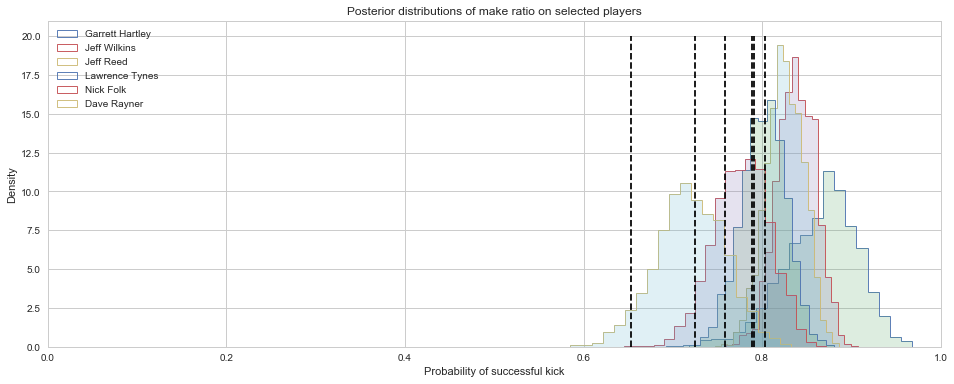

In [58]:
fig, ax = plt.subplots(figsize = (16,6))

for i in sample_idx:
    plt.hist(data.iloc[i, 4], bins=20, normed=True, alpha=0.9, histtype='step', lw=1, label=data.iloc[i, 0])
    plt.hist(data.iloc[i, 4], bins=20, normed=True, alpha=0.2, histtype='stepfilled', lw=3)
    plt.vlines(data.iloc[i, 5], 0, 20, linestyles='--')
    
plt.legend(loc='upper left')
plt.xlim(0, 1)
plt.xlabel('Probability of successful kick')
plt.ylabel('Density')
plt.title('Posterior distributions of make ratio on selected players')

The figure above shows the variability of the selected player's `make_ratio`. The vertical lines are the **95% least plausible value** of each distribution. Those vertical lines will be used to rank the players.

Let's compare the rankings between the original and the Bayesian methods...

In [125]:
data['orig_rank'] = np.argsort(-data['obs_make_ratio'])
data['bayes_rank'] = np.argsort(-data['lower_bound']).sort_values().reset_index()

In [144]:
data[['kicker', 'obs_make_ratio', 'total_kicks', 'lower_bound', 'orig_rank', 'bayes_rank']]\
.sort_values('bayes_rank')\
.head(18)

,kicker,obs_make_ratio,total_kicks,lower_bound,orig_rank,bayes_rank
1,Matt Stover,0.8687,386.0,0.836310,1,0
3,Rob Bironas,0.8610,259.0,0.821496,3,1
2,Robbie Gould,0.8616,260.0,0.820761,2,2
4,Shayne Graham,0.8543,297.0,0.818508,4,3
9,Adam Vinatieri,0.8431,446.0,0.812072,9,4
6,Joe Nedney,0.8480,295.0,0.810615,6,5
5,Mike Vanderjagt,0.8510,244.0,0.809317,5,6
13,John Kasay,0.8385,384.0,0.805499,13,7
14,Phil Dawson,0.8385,384.0,0.804946,14,8
16,David Akers,0.8315,535.0,0.804830,16,9


In [140]:
data[['kicker', 'obs_make_ratio', 'total_kicks', 'lower_bound', 'orig_rank', 'bayes_rank']]\
.sort_values('bayes_rank')\
.tail(10)

,kicker,obs_make_ratio,total_kicks,lower_bound,orig_rank,bayes_rank
48,John Hall,0.7485,228.0,0.700546,48,45
43,Mike Hollis,0.7701,113.0,0.696947,43,46
37,Steven Hauschka,0.7885,66.0,0.692372,37,47
47,Steve Christie,0.7500,160.0,0.688764,47,48
49,Graham Gano,0.7375,108.0,0.667837,49,49
50,Dave Rayner,0.7222,125.0,0.653561,50,50
51,Nick Novak,0.7188,89.0,0.636666,51,51
53,Jose Cortez,0.7067,106.0,0.631352,53,52
52,Tim Seder,0.7097,87.0,0.629359,52,53
54,Wade Richey,0.6607,85.0,0.569342,54,54


We can see that using the Bayesian method, the originally top player Garrett Hartley has moved to position 17. This is mainly due to the fact that he has had a lot fewer kicks, meaning higher the uncertainty of his ability. Whereas Matt Stover has moved to the top where he deserves.

As we look at the head and tail of the dataframe, we can see that the top ranked kickers generally have higher number of total kicks, whereas low ranked kickers have fewer. This makes sense as those players with fewer kicks have higher uncertainty and hence have wider distributions and lower 95% least plausible value.

# Appendix

## Closed form solution

Since Beta and binomial distributions have a conjugate relationship, the posterior distribution has a closed form solution (MCMC is not required here):  

$$Beta(a, b)$$ 
where $$a = 1 + suc$$ and $$b = 1 + (N - suc)$$

### Evaluate the 95% least plausible value

- We want to evaluate *x* such that 0.05 probability is less than *x*. This can be done by inverting the CDF of our posterior Beta distribution. 

- For easier/quicker evaluation of the CDF, we can use a Normal approximation for a Beta distribution when `a` and `b` are greater than 10.

- From Wikipedia, we know that for a Beta distribution

$$mu = \frac{a}{a + b}$$

$$var = \frac{ab}{(a + b)^2(a + b + 1)}$$


- Hence we can approximate x (lower bound) from:

$$0.05 = \Phi( \frac{x - mu}{std} )$$

$$x = mu - 1.65  std$$

In [ ]:
def get_conv_lpv(N, suc, threshold=0.95):
    """
    Conversion: least plausible value (lpv)
    
    Parameters
    ---
    N: int
        Total number of trials (look)
    suc: int
        Number of successes (book)
    threshold: float
        
    """
    
    # params for conversion posterior distribution
    a = 1 + suc
    b = 1 + (N - suc)
    
    # mean and variance of the Beta posterior distribution
    mu = a / (a + b)
    var = a * b / (((a + b)**2) * (a + b + 1))
    
    # normal approximation of Beta distribution to obtain least plausible value
    x = np.abs(norm.ppf(1 - threshold, mu, var**0.5))
    lpv = mu - x * var**0.5
    
    return lpv

# References
Cameron Davidson-Pilon, _Bayesian Methods for Hackers_